This notebook was used to explore a range of models, along with hyperparameter tuning, and oversampling techniques. This was used for experimentation so likely will not run chronologically.

# Imports

In [1]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
import os
import zipfile
import joblib
import random
import time
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
from glob import glob
import pprint

from tqdm.notebook import tqdm, trange
tqdm.pandas()

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import plotly.express as px

from src.config import PATH, DATA_DIR, MODELS_DIR
from src.data.create_dataset import DatasetComplete
from src.tools.tools import mean_average_precision_score
from src.models.models import fit_simple_model, fit_simple_model_cv, grid_search

from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              GradientBoostingClassifier)

from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay,
                             precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             roc_auc_score,
                             average_precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.combine import SMOTEENN, SMOTETomek

pd.options.plotting.backend = "plotly"
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
SEED = 42

# Create Dataset

## Unzip the Data

With the zipped data "purchaseprediction_fulldata.zip" in the ProductRecommendation/data directory

In [3]:
raw_fnames = [
    'customers','labels_predict',
    'labels_training','products',
    'purchases','views']

# check if file has already been unzipped
if all(os.path.exists(DATA_DIR/'raw'/f'{fname}.txt') for fname in raw_fnames):
    print('already unzipped')

# extract zipfile to 'raw'
else:
    assert ZIP_PATH.exists()
    # create directory if needed
    if not os.path.exists(DATA_DIR/'raw'):
        os.mkdir(DATA_DIR/'raw')
    # extract
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR / 'raw')

already unzipped


## Create and Save Training Dataset

Preprocess the raw datasets, imputing missing values and reducing data usage. Then save all to feather format for faster loading.

In [5]:
# if feather files alreeady exist then skip
if all(os.path.exists(DATA_DIR / 'interim' / f'{fname}.feather') for fname in raw_fnames):
    print('Processed feathers already exist')

# else create and save
else:
    save_processed_datasets_to_feather()

Processed feathers already exist


Create the combined processed dataset - with n folds

In [11]:
# # Initial dataset creation
# n_folds = 3
# INCLUDE_NEW_FEATURES = False

# # to start with keep many countries - the rest mapped to 'other'
# countries_to_keep = {'UK', 'France', 'United States', 'Germany','Australia',
#                      'Russia','Italy','Spain','Denmark','Unknown'}

# # create dataset
# data = DatasetComplete(random_seed=SEED)
# data.load_datasets()

# # use smaller sample
# # data.labels_training_df = data.labels_training_df[:10_000]

# # split data into k folds and prepare each dataset
# data.create_and_save_cross_validated_datasets(
#     n_folds=n_folds,
#     fold_id_save_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy',
#     fold_data_save_path=DATA_DIR/'processed',
#     use_new_features=INCLUDE_NEW_FEATURES,
#     countries_to_keep=countries_to_keep)

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
Cross validation split object created
fold 0 assigned
fold 1 assigned
fold 2 assigned
Preparing fold 0
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
views brand merged
transforming validation dataset
views productId merged
views productType merged
views brand merged
Fold 0 complete
Preparing fold 1
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
views brand merged
transforming validation dataset
views productId merged
views productType merged
views brand merged
Fold 1 complete
Preparing fold 2
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
vi

# Initial Modeling

Of the initial models trained XGBoost was the best performer and due to gpu acceleration was fast to train.

Load the Dataset - before similarity feature engineering.

## Load Data

In [13]:
n_folds = 3

# create dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()
data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed')

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


In [14]:
# for speedy iteration use just one fold
X_train = data.folds_data[0].train.copy()
y_train = X_train.pop('purchased')

X_valid = data.folds_data[0].valid.copy()
y_valid = X_valid.pop('purchased')

## Test Dummy Classifiers

Performance with a random classifier and a majority class classifier

In [15]:
# mAP accross all folds - random classifier
tqdm.pandas(leave=False)

mAP_scores = []
for fold_id, fold in tqdm(data.folds_data.items(), desc='fold', leave=False):
    mAP_scores.append(
        mean_average_precision_score(
            fold.valid.customerId.values,
            fold.valid.purchased.values,
            np.random.randint(2, size=len(fold.valid))))
    
print(f"""Random classifier mAP: {np.mean(mAP_scores):.3f}""")

fold:   0%|          | 0/3 [00:00<?, ?it/s]

Random classifier mAP: 0.161


In [16]:
# mAP accross all folds - majority classifier
tqdm.pandas(leave=False)

mAP_scores = []
for fold_id, fold in tqdm(data.folds_data.items(), desc='fold', leave=False):
    mAP_scores.append(
        mean_average_precision_score(
            fold.valid.customerId.values,
            fold.valid.purchased.values,
            np.zeros_like(fold.valid.customerId.values)))

print(f"""Always False classifier mAP: {np.mean(mAP_scores):.3f}""")

fold:   0%|          | 0/3 [00:00<?, ?it/s]

Always False classifier mAP: 0.140


## Train Simple Models

In [17]:
# settings used for initial xgboost classifiers
boost_param = dict(
    # base_score=0.5,
    # booster='gbtree',
    # colsample_bylevel=1,
    # colsample_bynode=0.5,
    # colsample_bytree=0.5,
    # enable_categorical=False,
    eval_metric='logloss',
    # importance_type=None,
    # interaction_constraints='',
    # learning_rate=0.30, # default 0.3
    # max_delta_step=0,
    # max_depth=4, # default 6
    # min_child_weight=1,
    # missing=nan,
    # monotone_constraints='()',
    # n_estimators=2000,
    # n_jobs=12,
    # num_parallel_tree=1,
    predictor='gpu_predictor',
    # random_state=0,
    # reg_alpha=50, # default 0
    # reg_lambda=1,
    # scale_pos_weight=200, # neg class is majority (False) 2% are true
    # sampling_method='gradient_based', # method to use to sample the training instances
    # subsample=0.3,
    tree_method='gpu_hist',
    use_label_encoder=False,
    # validate_parameters=1,
    verbosity=2
)

### No resampling

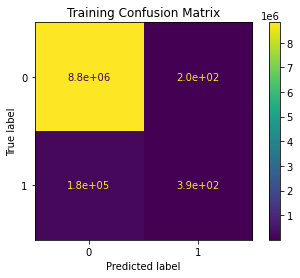

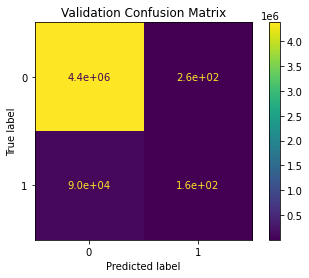

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.406153,0.120920,0.655348,0.002116,0.004218,0.979767,0.501046
valid,0.392299,0.099647,0.381068,0.001744,0.003472,0.979850,0.500843


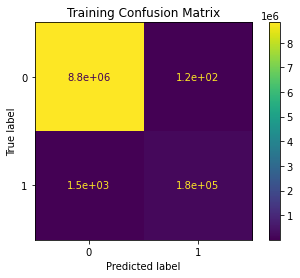

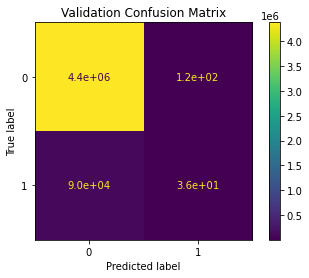

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.998187,0.999893,0.999315,0.991823,0.995555,0.999821,0.995904
valid,0.339013,0.074310,0.227848,0.000400,0.000798,0.979853,0.500186


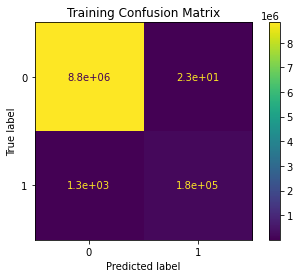

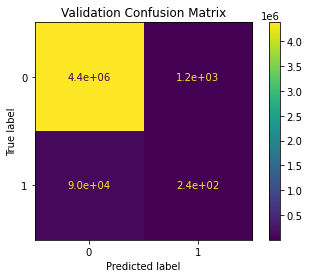

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.998192,0.999951,0.999873,0.992798,0.996323,0.999852,0.996398
valid,0.316818,0.063803,0.171631,0.002688,0.005293,0.979665,0.501211


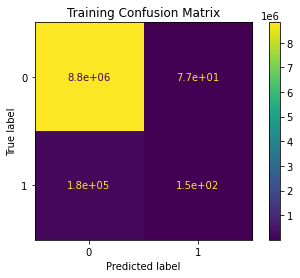

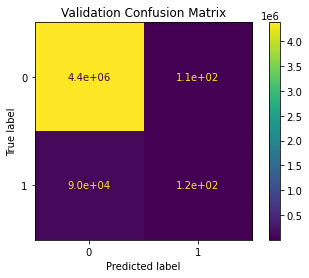

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.390538,0.095929,0.662281,0.000828,0.001653,0.979754,0.500409
valid,0.386919,0.094008,0.520362,0.001277,0.002548,0.979874,0.500627


mAP           avg_precision            \
                               train     valid         train     valid   
XGBClassifier               0.406153  0.392299      0.120920  0.099647   
RandomForestClassifier      0.998187  0.339013      0.999893  0.074310   
ExtraTreesClassifier        0.998192  0.316818      0.999951  0.063803   
GradientBoostingClassifier  0.390538  0.386919      0.095929  0.094008   

                           precision              recall                  f1  \
                               train     valid     train     valid     train   
XGBClassifier               0.655348  0.381068  0.002116  0.001744  0.004218   
RandomForestClassifier      0.999315  0.227848  0.991823  0.000400  0.995555   
ExtraTreesClassifier        0.999873  0.171631  0.992798  0.002688  0.996323   
GradientBoostingClassifier  0.662281  0.520362  0.000828  0.001277  0.001653   

                                      accuracy             roc_auc            
                               valid     train     valid     train     valid  
XGBClassifier               0.003472  0.979767  0.979850  0.501046  0.500843  
RandomForestClassifier      0.000798  0.999821  0.979853  0.995904  0.500186  
ExtraTreesClassifier        0.005293  0.999852  0.979665  0.996398  0.501211  
GradientBoostingClassifier  0.002548  0.979754  0.979874  0.500409  0.500627

In [18]:
# some simple models
models = [xgb.XGBClassifier(**boost_param), # 90 s
          RandomForestClassifier(n_jobs=-1, random_state=SEED), # 6 minutes
          ExtraTreesClassifier(n_jobs=-1, random_state=SEED),
          GradientBoostingClassifier(random_state=SEED) # very slow
          ]


results = {}
for model in models:
    # N.B models are updated in place
    model, results_df = fit_simple_model(model, X_train, y_train, X_valid, y_valid, resampler=False, n_partitions=10, confusion_matrix=True)
    # log results
    results[type(model).__name__] = results_df
    display(results_df)

results = pd.concat(results).unstack(1)
results

In [42]:
# print(results.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mAP</th>
      <th colspan="2" halign="left">avg_precision</th>
      <th colspan="2" halign="left">precision</th>
      <th colspan="2" halign="left">recall</th>
      <th colspan="2" halign="left">f1</th>
      <th colspan="2" halign="left">accuracy</th>
      <th colspan="2" halign="left">roc_auc</th>
    </tr>
    <tr>
      <th></th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>XGBClassifier</th>
      <td>0.406153</td>
      <td>0.392299</td>
      <td>0.120920</td>
      <td>0.099647</td>
      <td>0.655348</td>
      <td>0.381068</td>
      <td>0.002116</td>
      <td>0.001744</td>
      <td>0.004218</td>
      <td>0.003472</td>
      <td>0.979767</td>
      <td>0.979850</td>
      <td>0.501046</td>
      <td>0.500843</td>
    </tr>
    <tr>
      <th>RandomForestClassifier</th>
      <td>0.998187</td>
      <td>0.339013</td>
      <td>0.999893</td>
      <td>0.074310</td>
      <td>0.999315</td>
      <td>0.227848</td>
      <td>0.991823</td>
      <td>0.000400</td>
      <td>0.995555</td>
      <td>0.000798</td>
      <td>0.999821</td>
      <td>0.979853</td>
      <td>0.995904</td>
      <td>0.500186</td>
    </tr>
    <tr>
      <th>ExtraTreesClassifier</th>
      <td>0.998192</td>
      <td>0.316818</td>
      <td>0.999951</td>
      <td>0.063803</td>
      <td>0.999873</td>
      <td>0.171631</td>
      <td>0.992798</td>
      <td>0.002688</td>
      <td>0.996323</td>
      <td>0.005293</td>
      <td>0.999852</td>
      <td>0.979665</td>
      <td>0.996398</td>
      <td>0.501211</td>
    </tr>
    <tr>
      <th>GradientBoostingClassifier</th>
      <td>0.390538</td>
      <td>0.386919</td>
      <td>0.095929</td>
      <td>0.094008</td>
      <td>0.662281</td>
      <td>0.520362</td>
      <td>0.000828</td>
      <td>0.001277</td>
      <td>0.001653</td>
      <td>0.002548</td>
      <td>0.979754</td>
      <td>0.979874</td>
      <td>0.500409</td>
      <td>0.500627</td>
    </tr>
  </tbody>
</table>


In [20]:
# joblib.dump(models[0], MODELS_DIR/'initial_xgboost'/'xgb_0_2.joblib')

# joblib.dump(models[1], MODELS_DIR/'initial_model'/'rfc_0_2.joblib')
# joblib.dump(models[2], MODELS_DIR/'initial_model'/'etc_0_2.joblib')
# joblib.dump(models[3], MODELS_DIR/'initial_model'/'gbc_0_2.joblib')

# # clf = joblib.load(save_path)

### Resampliing

RFC and ETC perform farm better on the training data than the validation set, indicative of overfitting. The two gradient boosting approaches perform similarly on both sets and score higher. However, the Gradient Boosting Classifier was extremely slow to train ~45 minutes, meanwhile the XGB Classifier was fastest due to GPU acceleration.

Now test a range of resamplers on the XGBClassifier to see how that affects things.

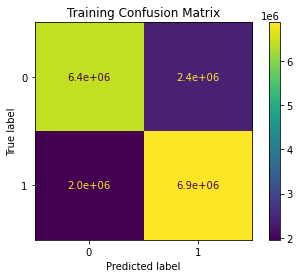

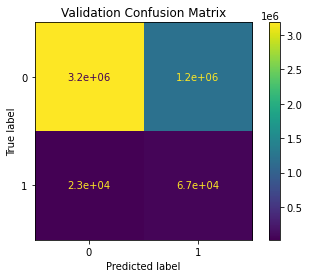

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.898405,0.816548,0.740219,0.778433,0.758846,0.752621,0.752621
valid,0.390845,0.098280,0.053309,0.749628,0.099539,0.727009,0.738086


255.43749904632568


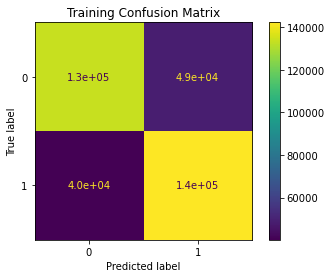

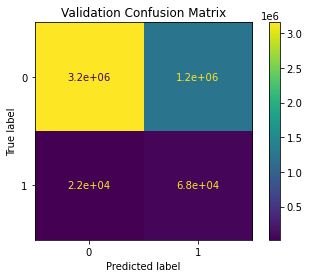

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.926910,0.827609,0.744686,0.779828,0.761852,0.756233,0.756233
valid,0.387436,0.096558,0.052409,0.754126,0.098008,0.720606,0.737022


40.2689995765686


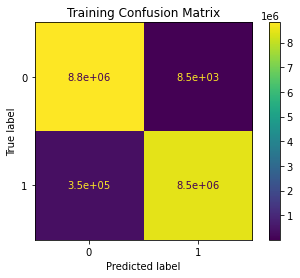

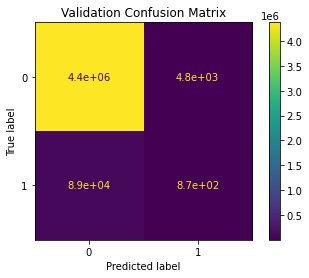

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.995906,0.995497,0.999001,0.960018,0.979122,0.979529,0.979529
valid,0.341304,0.067802,0.154283,0.009663,0.018188,0.979000,0.504288


927.561500787735


mAP           avg_precision           precision  \
                       train     valid         train     valid     train   
RandomOverSampler   0.898405  0.390845      0.816548  0.098280  0.740219   
RandomUnderSampler  0.926910  0.387436      0.827609  0.096558  0.744686   
SMOTE               0.995906  0.341304      0.995497  0.067802  0.999001   

                                recall                  f1            \
                       valid     train     valid     train     valid   
RandomOverSampler   0.053309  0.778433  0.749628  0.758846  0.099539   
RandomUnderSampler  0.052409  0.779828  0.754126  0.761852  0.098008   
SMOTE               0.154283  0.960018  0.009663  0.979122  0.018188   

                    accuracy             roc_auc            
                       train     valid     train     valid  
RandomOverSampler   0.752621  0.727009  0.752621  0.738086  
RandomUnderSampler  0.756233  0.720606  0.756233  0.737022  
SMOTE               0.979529  0.979000  0.979529  0.504288

In [21]:
# some simple resamplers
resamplers = [RandomOverSampler(random_state=SEED), # 4 mins
              RandomUnderSampler(random_state=SEED), # 40s
              SMOTE(random_state=SEED, n_jobs=-1), # 15 mins
            #   TomekLinks(n_jobs=-1) # > 12 hours
              ]

resample_results = {}
for resampler in resamplers:
    t = time.time()
    model, results_df = fit_simple_model(xgb.XGBClassifier(**boost_param),
                                         X_train, y_train, X_valid, y_valid,
                                         resampler=resampler, n_partitions=10,
                                         confusion_matrix=True)
    
    # log results
    resample_results[type(resampler).__name__] = results_df
    display(results_df)
    print(time.time()-t)
    

resample_results = pd.concat(resample_results).unstack(1)
resample_results

In [40]:
# print(resample_results.T.assign(TOMEKS='').T.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mAP</th>
      <th colspan="2" halign="left">avg_precision</th>
      <th colspan="2" halign="left">precision</th>
      <th colspan="2" halign="left">recall</th>
      <th colspan="2" halign="left">f1</th>
      <th colspan="2" halign="left">accuracy</th>
      <th colspan="2" halign="left">roc_auc</th>
    </tr>
    <tr>
      <th></th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>RandomOverSampler</th>
      <td>0.898405</td>
      <td>0.390845</td>
      <td>0.816548</td>
      <td>0.09828</td>
      <td>0.740219</td>
      <td>0.053309</td>
      <td>0.778433</td>
      <td>0.749628</td>
      <td>0.758846</td>
      <td>0.099539</td>
      <td>0.752621</td>
      <td>0.727009</td>
      <td>0.752621</td>
      <td>0.738086</td>
    </tr>
    <tr>
      <th>RandomUnderSampler</th>
      <td>0.92691</td>
      <td>0.387436</td>
      <td>0.827609</td>
      <td>0.096558</td>
      <td>0.744686</td>
      <td>0.052409</td>
      <td>0.779828</td>
      <td>0.754126</td>
      <td>0.761852</td>
      <td>0.098008</td>
      <td>0.756233</td>
      <td>0.720606</td>
      <td>0.756233</td>
      <td>0.737022</td>
    </tr>
    <tr>
      <th>SMOTE</th>
      <td>0.995906</td>
      <td>0.341304</td>
      <td>0.995497</td>
      <td>0.067802</td>
      <td>0.999001</td>
      <td>0.154283</td>
      <td>0.960018</td>
      <td>0.009663</td>
      <td>0.979122</td>
      <td>0.018188</td>
      <td>0.979529</td>
      <td>0.979</td>
      <td>0.979529</td>
      <td>0.504288</td>
    </tr>
    <tr>
      <th>TOMEKS</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
  </tbody>
</table>


Undersampling performed similarly to no/over sampling while training much quicker - may be worth exploring. SMOTE was very slow (15mins) performed worse and appeared to be overffitting. TOMEKS was not complete after >10 hours.

Resampling improved performance on the training sets but didn't have much effect on validation scores. Will try again with cross validation later.

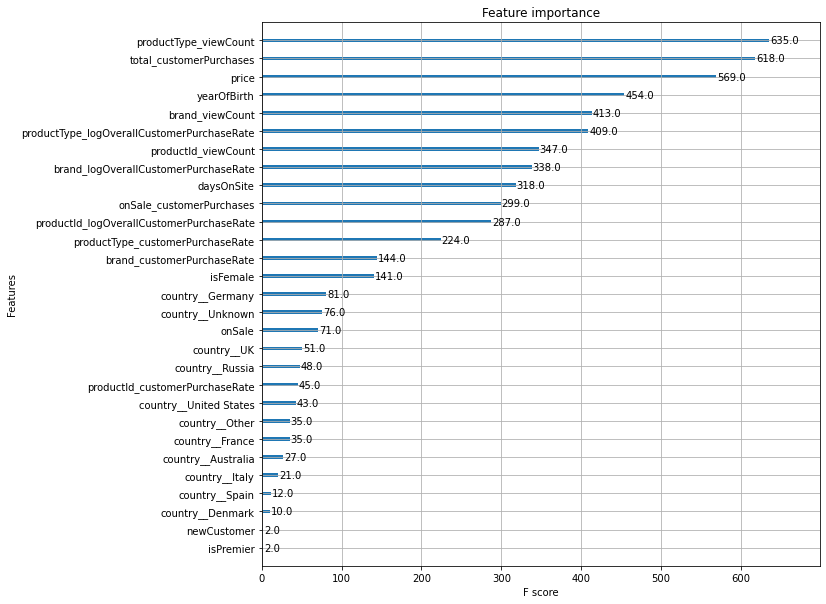

In [23]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(booster=models[0], ax=ax, importance_type="weight")
plt.show()

In [207]:
# # feat_importance = \
# (pd.DataFrame()
#  .assign(feature=models[1].feature_names_in_,
#          importance=models[1].feature_importances_)
#  .sort_values(by='importance', ascending=False)
#  .plot.bar(y='feature', x='importance', height=800, width=800))

# Improved Dataset

Repeat the above experiments with the additional feature engineering.

## Get the Data

This overwrites thee cv_folds_3.npy file, but that is fine as it is created with the same random seed.

In [26]:
# # Initial dataset creation
# n_folds = 3
# INCLUDE_NEW_FEATURES = True

# # to start with keep many countries - the rest mapped to 'other'
# countries_to_keep = {'UK', 'France', 'United States', 'Germany','Unknown'}

# # create dataset
# data = DatasetComplete(random_seed=SEED)
# data.load_datasets()

# # use smaller sample
# # data.labels_training_df = data.labels_training_df[:10_000]

# # split data into k folds and prepare each dataset
# data.create_and_save_cross_validated_datasets(
#     n_folds=n_folds,
#     fold_id_save_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy',
#     fold_data_save_path=DATA_DIR/'processed'/'Extra Features',
#     use_new_features=INCLUDE_NEW_FEATURES,
#     countries_to_keep=countries_to_keep)

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
Cross validation split object created
fold 0 assigned
fold 1 assigned
fold 2 assigned
Preparing fold 0
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
views brand merged
transforming validation dataset
views productId merged
views productType merged
views brand merged
Fold 0 complete
Preparing fold 1
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
views brand merged
transforming validation dataset
views productId merged
views productType merged
views brand merged
Fold 1 complete
Preparing fold 2
fitting training dataset
training dataset fit
transforming training dataset
views productId merged
views productType merged
vi

In [27]:
n_folds = 3

# create dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()
data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


In [28]:
to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']

In [29]:
# for speedy iteration use just one fold
X_train = data.folds_data[0].train.copy().drop(columns=to_drop)
y_train = X_train.pop('purchased')

X_valid = data.folds_data[0].valid.copy().drop(columns=to_drop)
y_valid = X_valid.pop('purchased')

## No resampling

In [30]:
# settings used for initial xgboost classifiers
boost_param = dict(
    eval_metric='logloss',
    predictor='gpu_predictor',
    tree_method='gpu_hist',
    use_label_encoder=False,
    verbosity=2
)

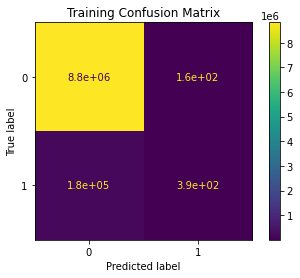

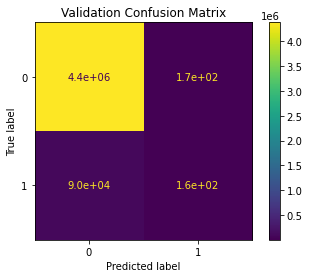

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.407936,0.121084,0.705776,0.002143,0.004273,0.979772,0.501062
valid,0.393897,0.101452,0.489489,0.001811,0.003608,0.979870,0.500886


99.54899907112122


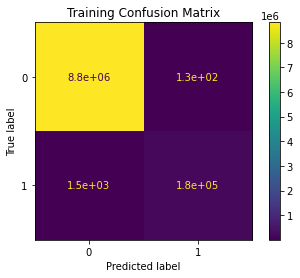

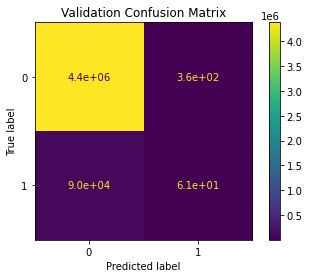

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.998175,0.99989,0.999260,0.991620,0.995425,0.999815,0.995802
valid,0.333339,0.06977,0.143529,0.000678,0.001349,0.979804,0.500297


613.8545024394989


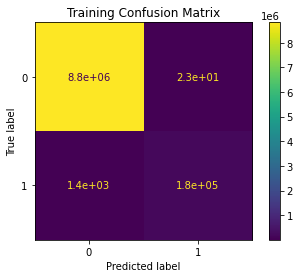

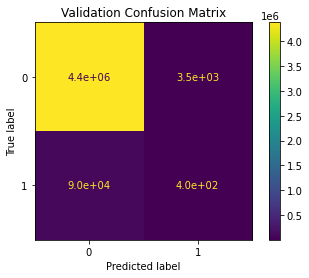

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.998179,0.999948,0.999873,0.992601,0.996224,0.999848,0.996299
valid,0.303447,0.056117,0.100178,0.004387,0.008407,0.979167,0.501789


596.5329985618591


mAP           avg_precision           precision  \
                           train     valid         train     valid     train   
XGBClassifier           0.407936  0.393897      0.121084  0.101452  0.705776   
RandomForestClassifier  0.998175  0.333339      0.999890  0.069770  0.999260   
ExtraTreesClassifier    0.998179  0.303447      0.999948  0.056117  0.999873   

                                    recall                  f1            \
                           valid     train     valid     train     valid   
XGBClassifier           0.489489  0.002143  0.001811  0.004273  0.003608   
RandomForestClassifier  0.143529  0.991620  0.000678  0.995425  0.001349   
ExtraTreesClassifier    0.100178  0.992601  0.004387  0.996224  0.008407   

                        accuracy             roc_auc            
                           train     valid     train     valid  
XGBClassifier           0.979772  0.979870  0.501062  0.500886  
RandomForestClassifier  0.999815  0.979804  0.995802  0.500297  
ExtraTreesClassifier    0.999848  0.979167  0.996299  0.501789

In [31]:
# some simple models
models = [xgb.XGBClassifier(**boost_param),
          RandomForestClassifier(n_jobs=-1, random_state=SEED), # 6 minutes
          ExtraTreesClassifier(n_jobs=-1, random_state=SEED),
        #   GradientBoostingClassifier(random_state=SEED) # very slow
          ]


results = {}
for model in models:
    t = time.time()
    # N.B models are updated in place
    model, results_df = fit_simple_model(model, X_train, y_train, X_valid, y_valid, resampler=False, n_partitions=10, confusion_matrix=True)
    # log results
    results[type(model).__name__] = results_df
    display(results_df)
    print(time.time()-t)

results = pd.concat(results).unstack(1)
results

In [46]:
# print(results.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mAP</th>
      <th colspan="2" halign="left">avg_precision</th>
      <th colspan="2" halign="left">precision</th>
      <th colspan="2" halign="left">recall</th>
      <th colspan="2" halign="left">f1</th>
      <th colspan="2" halign="left">accuracy</th>
      <th colspan="2" halign="left">roc_auc</th>
    </tr>
    <tr>
      <th></th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>XGBClassifier</th>
      <td>0.407936</td>
      <td>0.393897</td>
      <td>0.121084</td>
      <td>0.101452</td>
      <td>0.705776</td>
      <td>0.489489</td>
      <td>0.002143</td>
      <td>0.001811</td>
      <td>0.004273</td>
      <td>0.003608</td>
      <td>0.979772</td>
      <td>0.979870</td>
      <td>0.501062</td>
      <td>0.500886</td>
    </tr>
    <tr>
      <th>RandomForestClassifier</th>
      <td>0.998175</td>
      <td>0.333339</td>
      <td>0.999890</td>
      <td>0.069770</td>
      <td>0.999260</td>
      <td>0.143529</td>
      <td>0.991620</td>
      <td>0.000678</td>
      <td>0.995425</td>
      <td>0.001349</td>
      <td>0.999815</td>
      <td>0.979804</td>
      <td>0.995802</td>
      <td>0.500297</td>
    </tr>
    <tr>
      <th>ExtraTreesClassifier</th>
      <td>0.998179</td>
      <td>0.303447</td>
      <td>0.999948</td>
      <td>0.056117</td>
      <td>0.999873</td>
      <td>0.100178</td>
      <td>0.992601</td>
      <td>0.004387</td>
      <td>0.996224</td>
      <td>0.008407</td>
      <td>0.999848</td>
      <td>0.979167</td>
      <td>0.996299</td>
      <td>0.501789</td>
    </tr>
  </tbody>
</table>


In [38]:
# joblib.dump(models[0], MODELS_DIR/'initial_xgboost'/'new_feats_xgb_0_2.joblib')

# joblib.dump(models[1], MODELS_DIR/'initial_model'/'new_feats_rfc_0_2.joblib')
# joblib.dump(models[2], MODELS_DIR/'initial_model'/'new_feats_etc_0_2.joblib')
# # joblib.dump(models[3], MODELS_DIR/'initial_model'/'new_feats_gbc_0_2.joblib')

['c:\\Users\\ylene\\Documents\\Work\\Applications\\ASOS\\asos-product-prediction\\ASOSProductPrediction\\models\\initial_model\\new_feats_etc_0_2.joblib']

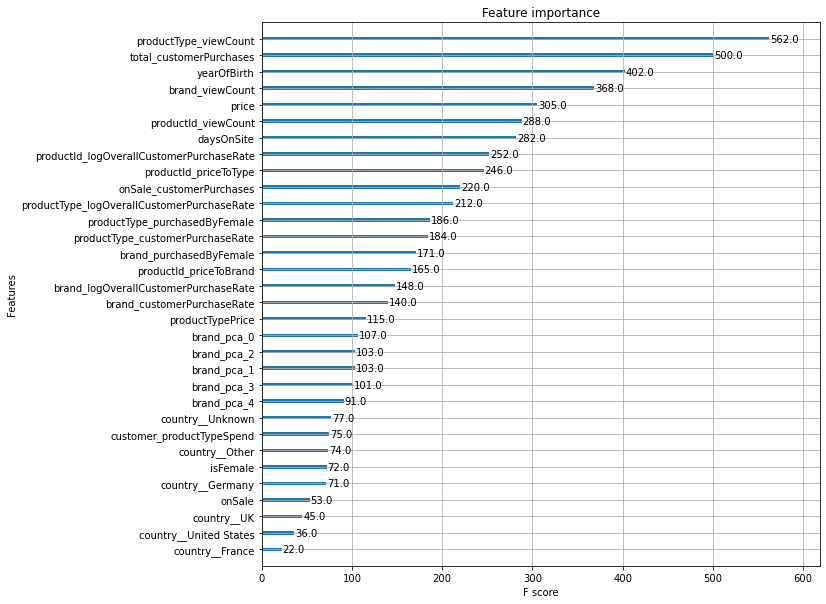

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(booster=models[0], ax=ax, importance_type="weight")
plt.show()

## With Resampling

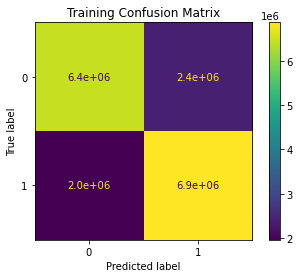

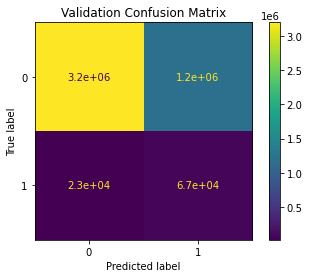

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.898677,0.816960,0.741932,0.778031,0.759553,0.753703,0.753703
valid,0.390980,0.099421,0.053700,0.748884,0.100214,0.729320,0.738901


318.6475007534027


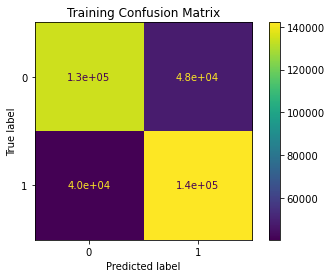

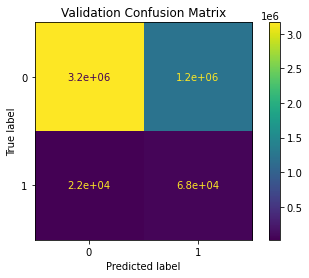

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.927283,0.829230,0.746676,0.779104,0.762546,0.757389,0.757389
valid,0.387719,0.096175,0.052747,0.753882,0.098596,0.722544,0.737891


52.41200017929077


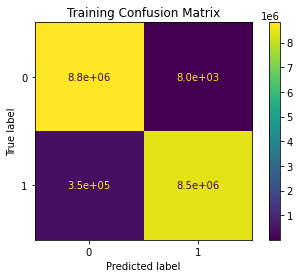

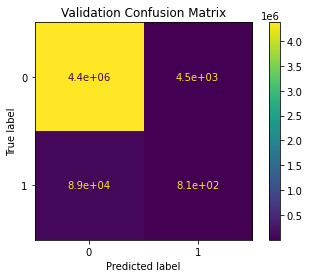

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.995926,0.995609,0.999056,0.960077,0.979179,0.979585,0.979585
valid,0.341553,0.068484,0.151809,0.009041,0.017066,0.979037,0.504002


1009.7479999065399


mAP           avg_precision           precision  \
                       train     valid         train     valid     train   
RandomOverSampler   0.898677  0.390980      0.816960  0.099421  0.741932   
RandomUnderSampler  0.927283  0.387719      0.829230  0.096175  0.746676   
SMOTE               0.995926  0.341553      0.995609  0.068484  0.999056   

                                recall                  f1            \
                       valid     train     valid     train     valid   
RandomOverSampler   0.053700  0.778031  0.748884  0.759553  0.100214   
RandomUnderSampler  0.052747  0.779104  0.753882  0.762546  0.098596   
SMOTE               0.151809  0.960077  0.009041  0.979179  0.017066   

                    accuracy             roc_auc            
                       train     valid     train     valid  
RandomOverSampler   0.753703  0.729320  0.753703  0.738901  
RandomUnderSampler  0.757389  0.722544  0.757389  0.737891  
SMOTE               0.979585  0.979037  0.979585  0.504002

In [34]:
# some simple resamplers
resamplers = [RandomOverSampler(random_state=SEED), # 4 mins
              RandomUnderSampler(random_state=SEED), # 40s
              SMOTE(random_state=SEED, n_jobs=-1), # 15 mins
            #   TomekLinks(n_jobs=-1) # > 12 hours
              ]

resample_results = {}
for resampler in resamplers:
    t = time.time()
    model, results_df = fit_simple_model(xgb.XGBClassifier(**boost_param),
                                         X_train, y_train, X_valid, y_valid,
                                         resampler=resampler, n_partitions=10,
                                         confusion_matrix=True)
    
    # log results
    resample_results[type(resampler).__name__] = results_df
    display(results_df)
    print(time.time()-t)
    

resample_results = pd.concat(resample_results).unstack(1)
resample_results

In [41]:
# print(resample_results.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mAP</th>
      <th colspan="2" halign="left">avg_precision</th>
      <th colspan="2" halign="left">precision</th>
      <th colspan="2" halign="left">recall</th>
      <th colspan="2" halign="left">f1</th>
      <th colspan="2" halign="left">accuracy</th>
      <th colspan="2" halign="left">roc_auc</th>
    </tr>
    <tr>
      <th></th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>RandomOverSampler</th>
      <td>0.898677</td>
      <td>0.390980</td>
      <td>0.816960</td>
      <td>0.099421</td>
      <td>0.741932</td>
      <td>0.053700</td>
      <td>0.778031</td>
      <td>0.748884</td>
      <td>0.759553</td>
      <td>0.100214</td>
      <td>0.753703</td>
      <td>0.729320</td>
      <td>0.753703</td>
      <td>0.738901</td>
    </tr>
    <tr>
      <th>RandomUnderSampler</th>
      <td>0.927283</td>
      <td>0.387719</td>
      <td>0.829230</td>
      <td>0.096175</td>
      <td>0.746676</td>
      <td>0.052747</td>
      <td>0.779104</td>
      <td>0.753882</td>
      <td>0.762546</td>
      <td>0.098596</td>
      <td>0.757389</td>
      <td>0.722544</td>
      <td>0.757389</td>
      <td>0.737891</td>
    </tr>
    <tr>
      <th>SMOTE</th>
      <td>0.995926</td>
      <td>0.341553</td>
      <td>0.995609</td>
      <td>0.068484</td>
      <td>0.999056</td>
      <td>0.151809</td>
      <td>0.960077</td>
      <td>0.009041</td>
      <td>0.979179</td>
      <td>0.017066</td>
      <td>0.979585</td>
      <td>0.979037</td>
      <td>0.979585</td>
      <td>0.504002</td>
    </tr>
  </tbody>
</table>


<table border="1" class="dataframe">
    <thead>
      <tr>
        <th rowspan="2" halign="left">Dataset</th>
        <th rowspan="2" halign="left">Sampling</th>
        <th rowspan="2" halign="left">Model</th>
        <th colspan="2" halign="left">mAP</th>
        <th colspan="2" halign="left">avg_precision</th>
        <th colspan="2" halign="left">precision</th>
        <th colspan="2" halign="left">recall</th>
        <th colspan="2" halign="left">f1</th>
        <th colspan="2" halign="left">accuracy</th>
        <th colspan="2" halign="left">roc_auc</th>
      </tr>
      <tr>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
        <th>train</th>
        <th>valid</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <th rowspan="8" halign="left">Initial</th>
        <th rowspan="4" halign="left">None</th>
        <th>XGBClassifier</th>
        <td>0.406153</td>
        <td>0.392299</td>
        <td>0.120920</td>
        <td>0.099647</td>
        <td>0.655348</td>
        <td>0.381068</td>
        <td>0.002116</td>
        <td>0.001744</td>
        <td>0.004218</td>
        <td>0.003472</td>
        <td>0.979767</td>
        <td>0.979850</td>
        <td>0.501046</td>
        <td>0.500843</td>
      </tr>
      <tr>
        <th>RandomForestClassifier</th>
        <td>0.998187</td>
        <td>0.339013</td>
        <td>0.999893</td>
        <td>0.074310</td>
        <td>0.999315</td>
        <td>0.227848</td>
        <td>0.991823</td>
        <td>0.000400</td>
        <td>0.995555</td>
        <td>0.000798</td>
        <td>0.999821</td>
        <td>0.979853</td>
        <td>0.995904</td>
        <td>0.500186</td>
      </tr>
      <tr>
        <th>ExtraTreesClassifier</th>
        <td>0.998192</td>
        <td>0.316818</td>
        <td>0.999951</td>
        <td>0.063803</td>
        <td>0.999873</td>
        <td>0.171631</td>
        <td>0.992798</td>
        <td>0.002688</td>
        <td>0.996323</td>
        <td>0.005293</td>
        <td>0.999852</td>
        <td>0.979665</td>
        <td>0.996398</td>
        <td>0.501211</td>
      </tr>
      <tr>
        <th>GradientBoostingClassifier</th>
        <td>0.390538</td>
        <td>0.386919</td>
        <td>0.095929</td>
        <td>0.094008</td>
        <td>0.662281</td>
        <td>0.520362</td>
        <td>0.000828</td>
        <td>0.001277</td>
        <td>0.001653</td>
        <td>0.002548</td>
        <td>0.979754</td>
        <td>0.979874</td>
        <td>0.500409</td>
        <td>0.500627</td>
      </tr>
    <tr>
      <th>RandomOverSampler</th>
      <th rowspan="4" halign="left">XGBClassifier</th>
      <td>0.898405</td>
      <td>0.390845</td>
      <td>0.816548</td>
      <td>0.09828</td>
      <td>0.740219</td>
      <td>0.053309</td>
      <td>0.778433</td>
      <td>0.749628</td>
      <td>0.758846</td>
      <td>0.099539</td>
      <td>0.752621</td>
      <td>0.727009</td>
      <td>0.752621</td>
      <td>0.738086</td>
    </tr>
    <tr>
      <th>RandomUnderSampler</th>
      <td>0.92691</td>
      <td>0.387436</td>
      <td>0.827609</td>
      <td>0.096558</td>
      <td>0.744686</td>
      <td>0.052409</td>
      <td>0.779828</td>
      <td>0.754126</td>
      <td>0.761852</td>
      <td>0.098008</td>
      <td>0.756233</td>
      <td>0.720606</td>
      <td>0.756233</td>
      <td>0.737022</td>
    </tr>
    <tr>
      <th>SMOTE</th>
      <td>0.995906</td>
      <td>0.341304</td>
      <td>0.995497</td>
      <td>0.067802</td>
      <td>0.999001</td>
      <td>0.154283</td>
      <td>0.960018</td>
      <td>0.009663</td>
      <td>0.979122</td>
      <td>0.018188</td>
      <td>0.979529</td>
      <td>0.979</td>
      <td>0.979529</td>
      <td>0.504288</td>
    </tr>
    <tr>
      <th>TOMEKS</th>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
      <td></td>
    </tr>
    <tr>
      <th rowspan="6" halign="left">Improved</th>
      <th rowspan="3" halign="left">None</th>
      <th>XGBClassifier</th>
      <td>0.407936</td>
      <td>0.393897</td>
      <td>0.121084</td>
      <td>0.101452</td>
      <td>0.705776</td>
      <td>0.489489</td>
      <td>0.002143</td>
      <td>0.001811</td>
      <td>0.004273</td>
      <td>0.003608</td>
      <td>0.979772</td>
      <td>0.979870</td>
      <td>0.501062</td>
      <td>0.500886</td>
    </tr>
    <tr>
      <th>RandomForestClassifier</th>
      <td>0.998175</td>
      <td>0.333339</td>
      <td>0.999890</td>
      <td>0.069770</td>
      <td>0.999260</td>
      <td>0.143529</td>
      <td>0.991620</td>
      <td>0.000678</td>
      <td>0.995425</td>
      <td>0.001349</td>
      <td>0.999815</td>
      <td>0.979804</td>
      <td>0.995802</td>
      <td>0.500297</td>
    </tr>
    <tr>
      <th>ExtraTreesClassifier</th>
      <td>0.998179</td>
      <td>0.303447</td>
      <td>0.999948</td>
      <td>0.056117</td>
      <td>0.999873</td>
      <td>0.100178</td>
      <td>0.992601</td>
      <td>0.004387</td>
      <td>0.996224</td>
      <td>0.008407</td>
      <td>0.999848</td>
      <td>0.979167</td>
      <td>0.996299</td>
      <td>0.501789</td>
    </tr>
    <tr>
      <th>RandomOverSampler</th>
      <th rowspan="3" halign="left">XGBClassifier</th>
      <td>0.898677</td>
      <td>0.390980</td>
      <td>0.816960</td>
      <td>0.099421</td>
      <td>0.741932</td>
      <td>0.053700</td>
      <td>0.778031</td>
      <td>0.748884</td>
      <td>0.759553</td>
      <td>0.100214</td>
      <td>0.753703</td>
      <td>0.729320</td>
      <td>0.753703</td>
      <td>0.738901</td>
    </tr>
    <tr>
      <th>RandomUnderSampler</th>
      <td>0.927283</td>
      <td>0.387719</td>
      <td>0.829230</td>
      <td>0.096175</td>
      <td>0.746676</td>
      <td>0.052747</td>
      <td>0.779104</td>
      <td>0.753882</td>
      <td>0.762546</td>
      <td>0.098596</td>
      <td>0.757389</td>
      <td>0.722544</td>
      <td>0.757389</td>
      <td>0.737891</td>
    </tr>
    <tr>
      <th>SMOTE</th>
      <td>0.995926</td>
      <td>0.341553</td>
      <td>0.995609</td>
      <td>0.068484</td>
      <td>0.999056</td>
      <td>0.151809</td>
      <td>0.960077</td>
      <td>0.009041</td>
      <td>0.979179</td>
      <td>0.017066</td>
      <td>0.979585</td>
      <td>0.979037</td>
      <td>0.979585</td>
      <td>0.504002</td>
    </tr>
  </tbody>
</table>


## Cross Validate comparison between datasets

In [20]:
# settings used for initial xgboost classifiers
boost_param = dict(
    eval_metric='logloss',
    predictor='gpu_predictor',
    tree_method='gpu_hist',
    use_label_encoder=False,
    verbosity=2
)

In [21]:
n_folds = 3
model = xgb.XGBClassifier

# create dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()
data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')

# Old dataset
to_drop = []
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed')
old_models, old_results = fit_simple_model_cv(
    data, model, model_params=boost_param, to_drop=to_drop, n_folds=n_folds)

# new dataset
to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')
new_models, new_results = fit_simple_model_cv(
    data, model, model_params=boost_param, to_drop=to_drop, n_folds=n_folds)

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.406153,0.120920,0.655348,0.002116,0.004218,0.979767,0.501046
valid,0.392299,0.099647,0.381068,0.001744,0.003472,0.979850,0.500843


82.31048560142517


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.404680,0.119795,0.746774,0.002560,0.005103,0.979896,0.501271
valid,0.392987,0.098822,0.230620,0.001298,0.002582,0.979578,0.500604


84.01749968528748


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.403357,0.120067,0.669797,0.002356,0.004695,0.979780,0.501166
valid,0.396085,0.099089,0.321285,0.000881,0.001757,0.979833,0.500421


82.22704768180847


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.407936,0.121084,0.705776,0.002143,0.004273,0.979772,0.501062
valid,0.393897,0.101452,0.489489,0.001811,0.003608,0.979870,0.500886


92.46879744529724


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.406756,0.120145,0.720539,0.002367,0.004718,0.979891,0.501174
valid,0.393943,0.099781,0.200418,0.001047,0.002084,0.979576,0.500480


91.06542110443115


,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.406151,0.120887,0.668342,0.002196,0.004378,0.979778,0.501087
valid,0.396728,0.100440,0.339713,0.000782,0.001560,0.979838,0.500375


91.223628282547


In [29]:
# print(pd.concat([old_results, new_results], axis=0, keys=['Initial','Improved']).groupby(level=0).mean().to_html())

<table border="1" class="dataframe">
  <thead>
    <tr>
      <th></th>
      <th colspan="2" halign="left">mAP</th>
      <th colspan="2" halign="left">avg_precision</th>
      <th colspan="2" halign="left">precision</th>
      <th colspan="2" halign="left">recall</th>
      <th colspan="2" halign="left">f1</th>
      <th colspan="2" halign="left">accuracy</th>
      <th colspan="2" halign="left">roc_auc</th>
    </tr>
    <tr>
      <th></th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
      <th>train</th>
      <th>valid</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Improved</th>
      <td>0.406948</td>
      <td>0.394856</td>
      <td>0.120705</td>
      <td>0.100558</td>
      <td>0.698219</td>
      <td>0.343207</td>
      <td>0.002235</td>
      <td>0.001213</td>
      <td>0.004456</td>
      <td>0.002417</td>
      <td>0.979814</td>
      <td>0.979761</td>
      <td>0.501108</td>
      <td>0.500580</td>
    </tr>
    <tr>
      <th>Initial</th>
      <td>0.404730</td>
      <td>0.393791</td>
      <td>0.120261</td>
      <td>0.099186</td>
      <td>0.690640</td>
      <td>0.310991</td>
      <td>0.002344</td>
      <td>0.001308</td>
      <td>0.004672</td>
      <td>0.002604</td>
      <td>0.979814</td>
      <td>0.979754</td>
      <td>0.501161</td>
      <td>0.500623</td>
    </tr>
  </tbody>
</table>


It really does seem like the additional feature engineering had no effect at all.

# Hyperparameter Search

## XGBoost Tuning

In [3]:
param_grid = dict(
    learning_rate=[0.01, 0.1, 0.3, 0.8],
    min_split_loss=[0, 0.1, 1, 10, 100],
    max_depth=[2, 6, 10, 20], # Maximum depth of a tree
    subsample=[0.8, 1],
    sampling_method=['gradient_based','uniform'],
    colsample_bynode=[1], # tried 0.8
    colsample_bytree=[1],
    reg_lambda=[1,3,10,50], # L2 regularization
    reg_alpha=[0, 1, 10, 100], # L1 regularization
    tree_method=['gpu_hist'],
    scale_pos_weight=[1], # Control the balance of positive and negative weights (50 is ideal)
    n_estimators=[100,500,1000],
    eval_metric=['logloss'],
    seed=[SEED],
    use_label_encoder=[False],
)

In [3]:
n_folds = 3
base_model = xgb.XGBClassifier
to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']

# get dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()
data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


Train without resampling

In [3]:
# ckpt_files = [MODELS_DIR/'grid_search'/'results_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'run_params_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'names_list_ckpt.joblib']

# resampler = False

# results = grid_search(
#     data,
#     base_model,
#     param_grid,
#     to_drop,
#     n_folds=3,
#     resampler=resampler,
#     n_partitions=10,
#     ckpt_files=ckpt_files,
#     continue_training=True,
#     n_runs=100,
#     sample=False)

results = joblib.load(MODELS_DIR/'grid_search'/'results_ckpt.joblib')

display(
pd.concat(results, keys=[f'run {x:02}' for x in range(len(results))])
.drop(columns=['precision','recall', 'f1','accuracy',
                'roc_auc',('time','valid'), 'tree_method' ,
                'eval_metric', 'use_label_encoder','seed'])
.groupby(level=0)
.agg(lambda g: g.mean() if g.name[1]!='' else g[0])
.assign(time=lambda df: df.time.round().astype(int),
        mAP=lambda df: df.mAP.round(4),
        avg_precision=lambda df: df.avg_precision.round(4))
.sort_values(by=('mAP','valid'))
.iloc[-10:])

mAP         avg_precision          time learning_rate  \
         train   valid         train   valid train                 
run 02  0.4307  0.3855        0.1077  0.0882   218        0.0001   
run 15  0.3875  0.3856        0.0978  0.0949    86        0.5000   
run 22  0.4091  0.3868        0.1183  0.0953    89        0.5000   
run 11  0.3888  0.3884        0.0934  0.0922   163        0.0100   
run 20  0.4017  0.3899        0.1159  0.0984    86        0.5000   
run 19  0.3953  0.3900        0.1064  0.0980    99        0.5000   
run 12  0.3922  0.3904        0.0961  0.0928   132        0.0100   
run 18  0.3948  0.3936        0.1015  0.0990   151        0.1000   
run 13  0.5059  0.3943        0.1682  0.0996   135        0.1000   
run 14  0.4025  0.3962        0.1113  0.1015   163        0.5000   

       min_split_loss max_depth subsample sampling_method colsample_bynode  \
                                                                             
run 02          100.0        20       0.8         uniform              0.8   
run 15          100.0         6       0.8  gradient_based              0.8   
run 22          100.0        10       0.8  gradient_based              1.0   
run 11            0.1         2       0.8  gradient_based              0.8   
run 20           10.0        10       0.8  gradient_based              1.0   
run 19           10.0         6       0.8  gradient_based              1.0   
run 12          100.0        20       1.0  gradient_based              1.0   
run 18            0.1         2       0.8         uniform              0.8   
run 13          100.0        20       0.8  gradient_based              1.0   
run 14            0.0         2       0.8  gradient_based              0.8   

       colsample_bytree reg_lambda reg_alpha scale_pos_weight n_estimators  
                                                                            
run 02              1.0         50         0               50           50  
run 15              1.0         50         1                1          100  
run 22              1.0         50         0               50          100  
run 11              0.8          1         0                1         2000  
run 20              1.0          3        10                1           50  
run 19              1.0          3        10                1          500  
run 12              0.8          3         0                1          500  
run 18              0.8          1         0               50         2000  
run 13              1.0         10        10               50          100  
run 14              0.8         10         0                1         2000

Try again with undersampling. Models train far faster without significant loss of performance.

In [4]:
# ckpt_files = [MODELS_DIR/'grid_search'/'rus_results_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'rus_run_params_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'rus_names_list_ckpt.joblib']

# resampler = RandomUnderSampler(random_state=SEED)

# results = grid_search(
#     data,
#     base_model,
#     param_grid,
#     to_drop,
#     n_folds=3,
#     resampler=resampler,
#     n_partitions=10,
#     ckpt_files=ckpt_files,
#     continue_training=False,
#     n_runs=100,
#     sample=False)

results = joblib.load(MODELS_DIR/'grid_search'/'rus_results_ckpt.joblib')

display(
pd.concat(results, keys=[f'run {x:02}' for x in range(len(results))])
.drop(columns=['precision','recall', 'f1','accuracy',
                'roc_auc',('time','valid'), 'tree_method' ,
                'eval_metric', 'use_label_encoder','seed'])
.groupby(level=0)
.agg(lambda g: g.mean() if g.name[1]!='' else g[0])
.assign(time=lambda df: df.time.round().astype(int),
        mAP=lambda df: df.mAP.round(4),
        avg_precision=lambda df: df.avg_precision.round(4))
.sort_values(by=('mAP','valid'))
.iloc[-10:])

mAP         avg_precision          time learning_rate  \
         train   valid         train   valid train                 
run 31  0.9845  0.3915        0.9632  0.0968   932          0.01   
run 99  0.9213  0.3918        0.8039  0.0981    43          0.30   
run 77  0.9210  0.3919        0.8026  0.0980    46          0.10   
run 65  0.9222  0.3921        0.8067  0.0988    43          0.10   
run 82  0.9394  0.3921        0.8630  0.0983    49          0.10   
run 03  0.9232  0.3925        0.8111  0.0993    43          0.10   
run 66  0.9275  0.3926        0.8246  0.0994    44          0.10   
run 08  0.9270  0.3931        0.8220  0.0979    69          0.01   
run 54  0.9331  0.3934        0.8442  0.0984    82          0.01   
run 67  0.9269  0.3959        0.8223  0.1010    71          0.01   

       min_split_loss max_depth subsample sampling_method colsample_bynode  \
                                                                             
run 31            0.0        20       0.8         uniform                1   
run 99            0.1         2       1.0  gradient_based                1   
run 77            1.0         2       1.0         uniform                1   
run 65           10.0         6       1.0         uniform                1   
run 82            0.0        10       1.0         uniform                1   
run 03            1.0         6       0.8         uniform                1   
run 66           10.0        10       1.0  gradient_based                1   
run 08            1.0        10       1.0         uniform                1   
run 54            0.0        10       0.8  gradient_based                1   
run 67           10.0        10       0.8         uniform                1   

       colsample_bytree reg_lambda reg_alpha scale_pos_weight n_estimators  
                                                                            
run 31                1         10         0                1          500  
run 99                1         10        10                1          500  
run 77                1          3         1                1         1000  
run 65                1          1        10                1          100  
run 82                1          3         0                1          100  
run 03                1         10         0                1          100  
run 66                1          1         0                1          100  
run 08                1         10        10                1          500  
run 54                1          1         0                1          500  
run 67                1          3         0                1         1000

Try a very large model with strong regularisation.

In [5]:
# n_folds = 3
# base_model = xgb.XGBClassifier
# to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']

# # get dataset
# data = DatasetComplete(random_seed=SEED)
# data.load_datasets()
# data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
# data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')

# param_grid = dict(
#     learning_rate=[0.01],
#     min_split_loss=[1],
#     max_depth=[10], # Maximum depth of a tree
#     subsample=[0.5],
#     sampling_method=['gradient_based'],
#     colsample_bynode=[1], # tried 0.8
#     colsample_bytree=[1],
#     reg_lambda=[10], # L2 regularization
#     reg_alpha=[20], # L1 regularization
#     tree_method=['gpu_hist'],
#     scale_pos_weight=[1], # Control the balance of positive and negative weights (50 is ideal)
#     n_estimators=[4000],
#     eval_metric=['logloss'],
#     seed=[SEED],
#     use_label_encoder=[False],
# )

# ckpt_files = [MODELS_DIR/'grid_search'/'big_4000_results_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'big_4000_run_params_ckpt.joblib',
#               MODELS_DIR/'grid_search'/'big_4000_names_list_ckpt.joblib']

# resampler = RandomUnderSampler(random_state=SEED)

# results = grid_search(
#     data,
#     base_model,
#     param_grid,
#     to_drop,
#     n_folds=3,
#     resampler=resampler,
#     n_partitions=10,
#     ckpt_files=ckpt_files,
#     continue_training=False,
#     n_runs=1,
#     sample=False)

results = joblib.load(MODELS_DIR/'grid_search'/'big_4000_results_ckpt.joblib')

display(
pd.concat(results, keys=[f'run {x:02}' for x in range(len(results))])
.drop(columns=['precision','recall', 'f1','accuracy',
                'roc_auc',('time','valid'), 'tree_method' ,
                'eval_metric', 'use_label_encoder','seed'])
.groupby(level=0)
.agg(lambda g: g.mean() if g.name[1]!='' else g[0])
.assign(time=lambda df: df.time.round().astype(int),
        mAP=lambda df: df.mAP.round(4),
        avg_precision=lambda df: df.avg_precision.round(4))
.sort_values(by=('mAP','valid'))
.iloc[-10:])

mAP         avg_precision         time learning_rate  \
         train   valid         train  valid train                 
run 00  0.9414  0.3948        0.8648  0.101   242          0.01   

       min_split_loss max_depth subsample sampling_method colsample_bynode  \
                                                                             
run 00              1        10       0.5  gradient_based                1   

       colsample_bytree reg_lambda reg_alpha scale_pos_weight n_estimators  
                                                                            
run 00                1         10        20                1         4000

In [13]:
print("""learning_rate                 0.01
min_split_loss                10.0
max_depth                       10
subsample                      0.8
sampling_method            uniform
colsample_bynode                 1
colsample_bytree                 1
reg_lambda                       3
reg_alpha                        0
scale_pos_weight                 1
n_estimators                  1000""")

learning_rate                 0.01
min_split_loss                10.0
max_depth                       10
subsample                      0.8
sampling_method            uniform
colsample_bynode                 1
colsample_bytree                 1
reg_lambda                       3
reg_alpha                        0
scale_pos_weight                 1
n_estimators                  1000


The final model chosen was the best performing undersampling model whith a mAP score of 0.3959 on the validation dataset. This trained in less than half the time of the best model without resampling while sacrificingh less than 1% performance.

# Probability Calibration

Probabilities are already well calibrated when no resampling is done but for the randomly undersampled model it is way off. The rebalancing function brings the predicted probabilities back in line

In [184]:
boost_param = dict(
    learning_rate=0.01,
    min_split_loss=10,
    max_depth=10,
    subsample=0.8,
    sampling_method='uniform',
    colsample_bynode=1,
    colsample_bytree=1,
    reg_lambda=3,
    reg_alpha=0,
    tree_method='gpu_hist',
    scale_pos_weight=1,
    n_estimators=1000,
    eval_metric='logloss',
    seed=SEED,
    use_label_encoder=False,
)

In [185]:
n_folds = 3
base_model = xgb.XGBClassifier
to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']

# get dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()
data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


In [186]:
# for speedy iteration use just one fold
X_train = data.folds_data[0].train.copy().drop(columns=to_drop)
y_train = X_train.pop('purchased')

X_valid = data.folds_data[0].valid.copy().drop(columns=to_drop)
y_valid = X_valid.pop('purchased')

# this time resample outside training loop
resampler = RandomUnderSampler(random_state=SEED)
X_train, y_train = resampler.fit_resample(X_train, y_train)

In [187]:
resampler = RandomUnderSampler(random_state=SEED)

model, results_df = fit_simple_model(
    xgb.XGBClassifier(**boost_param),
    X_train, y_train, X_valid, y_valid,
    resampler=False, n_partitions=10,
    confusion_matrix=False)

results_df

,mAP,avg_precision,precision,recall,f1,accuracy,roc_auc
train,0.926493,0.822147,0.743162,0.778655,0.760494,0.754775,0.754775
valid,0.393899,0.100057,0.052839,0.759780,0.098807,0.721036,0.740010


In [188]:
#making predictions for the test set
#probabilities
y_pred = model.predict_proba(X_valid.drop(columns=['customerId']))[:,1]

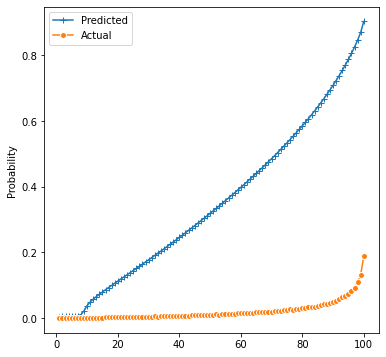

In [189]:
#Now looking at the calibration
def cal_data(y_pred, y_true, bins, plot=False, figsize=(6,4), save_plot=False):
    """Adapted from
    https://andrewpwheeler.com/2020/07/04/adjusting-predicted-probabilities-for-sampling/"""
    
    cal_dat = pd.DataFrame()
    cal_dat['y_pred'] = y_pred
    cal_dat['y_true'] = y_true
    
    cal_dat['Count'] = 1
    # split our preds into 100 bins by quantile
    cal_dat['Bin'] = pd.qcut(cal_dat['y_pred'], bins, range(bins) ).astype(int) + 1
    
    # get sum of probabilities for each bin
    agg_bins = cal_dat.groupby('Bin', as_index=False)[['Count','y_pred','y_true']].sum()
    # convert to a proportion
    agg_bins['Predicted'] = agg_bins['y_pred']/agg_bins['Count']
    agg_bins['Actual'] = agg_bins['y_true']/agg_bins['Count']
    
    if plot:
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(agg_bins['Bin'], agg_bins['Predicted'], marker='+', label='Predicted')
        ax.plot(agg_bins['Bin'], agg_bins['Actual'], marker='o', markeredgecolor='w', label='Actual')
        ax.set_ylabel('Probability')
        ax.legend(loc='upper left')
        if save_plot:
            plt.savefig(save_plot, dpi=500, bbox_inches='tight')
        plt.show()
    return agg_bins

cal_down = cal_data(
    y_pred=y_pred,
    y_true=y_valid,
    bins=100,
    plot=True,
    figsize=(6,6))

In the above figure we split our predicted probabilites into 100 quantiles. For each quantile we sum our predicted probabilities and divide by count. This represents the proportion of samples in each bin that our model expects will be in the true class. We then compare this to the real proportion, from the true classes.

So, consider the top 1% quantile, the customer-product pairs with the highest predicted probability of leading to a purchase according to out model. Our model would expect over 80% of these pairs to be the True class, but in reality only 20% are.

Our model is poorly calibrated and overpredicts purchase probabilities.

We can solve this by adjusting the predictions according to the class distributions in the original dataset and the oversampled dataset.

In [190]:
def get_trueprob(n_folds=3):
    # get dataset
    data = DatasetComplete(random_seed=SEED)
    data.load_datasets()
    data.assign_folds(load_from_path=DATA_DIR/'interim'/f'cv_folds_{n_folds}.npy')
    data.load_nfolds_from_files(n_folds=n_folds, save_filepath=DATA_DIR/'processed'/'Extra Features')

    return data.folds_data[0].train.copy().purchased.mean()

In [191]:
#Rebalancing function
#rewrite from
# https://andrewpwheeler.com/2020/07/04/adjusting-predicted-probabilities-for-sampling/
def classadjust(condprobs,wrongprob,trueprob):
    a = condprobs/(wrongprob/trueprob)
    comp_cond = 1 - condprobs
    comp_wrong = 1 - wrongprob
    comp_true = 1 - trueprob
    b = comp_cond/(comp_wrong/comp_true)
    return a/(a+b)

wrongprob = y_train.mean() # % true class in resampled dataset
trueprob = get_trueprob(); # % true class in original dataset

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED
fold ids loaded from file


In [192]:
print(wrongprob, trueprob, sep='\n')

0.5
0.02025377916357377


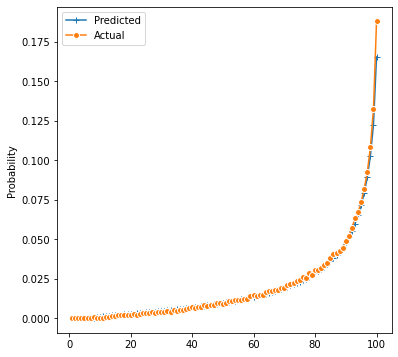

In [193]:
y_pred_adj = classadjust(y_pred, wrongprob, trueprob)

cal_down = cal_data(
    y_pred=y_pred_adj,
    y_true=y_valid,
    bins=100,
    plot=True,
    figsize=(6,6))

# Train Final Model

In [56]:
# # Full dataset creation
# INCLUDE_NEW_FEATURES = True
# countries_to_keep = {'UK', 'France', 'United States', 'Germany','Unknown'}

# # create dataset
# data = DatasetComplete(random_seed=SEED)
# data.load_datasets()

# data.create_train_valid_datasets(
#     labels_train_df=data.labels_training_df,
#     labels_valid_df=data.labels_testing_df,
#     customer_df=data.customer_df,
#     purchase_df=data.purchase_df,
#     product_df=data.product_df,
#     views_df=data.views_df,
#     use_new_features=INCLUDE_NEW_FEATURES,
#     countries_to_keep=countries_to_keep)

# data.save_datasets(
#     DATA_DIR/'processed'/'full'/f'train_full.feather',
#     DATA_DIR/'processed'/'full'/f'valid_full.feather')

data.load_datasets_from_file(
    DATA_DIR/'processed'/'full'/f'train_full.feather',
    DATA_DIR/'processed'/'full'/f'valid_full.feather')

In [57]:
# for probability calibration
trueprob = data.train.purchased.mean() # % true class in original dataset
trueprob

0.020212026484729476

In [58]:
# resample
sampler = RandomUnderSampler(random_state=42)
data.train, _ = sampler.fit_resample(data.train, data.train.purchased)

In [59]:
# for probability calibration
wrongprob = data.train.purchased.mean() # % true class in resampled dataset
wrongprob

0.5

In [62]:
# remember to drop unwanted columns
to_drop = ['newCustomer','isPremier','productId_customerPurchaseRate']
data.train = data.train.drop(columns=to_drop)
data.valid = data.valid.drop(columns=to_drop)

In [63]:
# model
params = dict(
    learning_rate=0.01,
    min_split_loss=10,
    max_depth=10,
    subsample=0.8,
    sampling_method='uniform',
    colsample_bynode=1,
    colsample_bytree=1,
    reg_lambda=3,
    reg_alpha=0,
    tree_method='gpu_hist',
    scale_pos_weight=1,
    n_estimators=1000,
    eval_metric='logloss',
    seed=SEED,
    use_label_encoder=False,
)

model = xgb.XGBClassifier(**params)
model.fit(data.train.drop(columns=['purchased','customerId']),
          data.train.purchased)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=10, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, min_split_loss=10, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=24,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=3, sampling_method='uniform',
              scale_pos_weight=1, seed=42, subsample=0.8,
              tree_method='gpu_hist', ...)

In [64]:
def classadjust(condprobs,wrongprob,trueprob):
    a = condprobs/(wrongprob/trueprob)
    comp_cond = 1 - condprobs
    comp_wrong = 1 - wrongprob
    comp_true = 1 - trueprob
    b = comp_cond/(comp_wrong/comp_true)
    return a/(a+b)

# making predictions for the test set probabilities
y_pred = model.predict_proba(data.valid.drop(columns=['purchase_probability','customerId']))[:,1]
y_pred_adj = classadjust(y_pred, wrongprob, trueprob)

Get labels for testing data.

In [65]:
y_valid = \
(data.labels_testing_df
 .merge(data.purchase_df.query("""date > '12-31-2016 23:59:59'"""), on=['productId','customerId'], how='left')
 [['productId','customerId','purchase_probability','purchasePrice']]
 .rename(columns={'purchasePrice':'purchased'}))

y_valid.loc[y_valid.purchased.notna(), 'purchased'] = True
y_valid.loc[y_valid.purchased.isna(), 'purchased'] = False

In [68]:
(mean_average_precision_score(y_valid.customerId, y_valid.purchased.astype(int), y_pred),
 mean_average_precision_score(y_valid.customerId, y_valid.purchased.astype(int), y_pred_adj))

(0.3990316814283693, 0.3990316814283693)

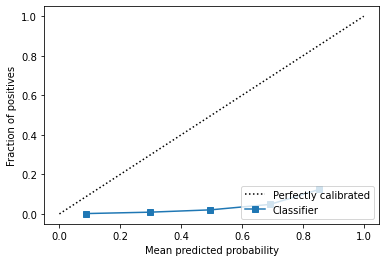

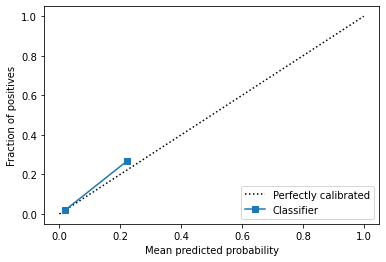

In [69]:
from sklearn.calibration import CalibrationDisplay

disp = CalibrationDisplay.from_predictions(y_valid.purchased.astype(int), y_pred)
plt.show()

disp = CalibrationDisplay.from_predictions(y_valid.purchased.astype(int), y_pred_adj)
plt.show()

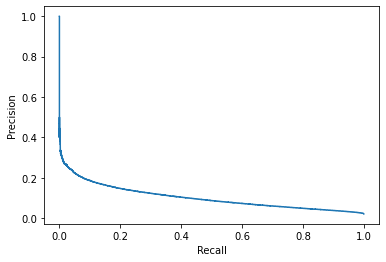

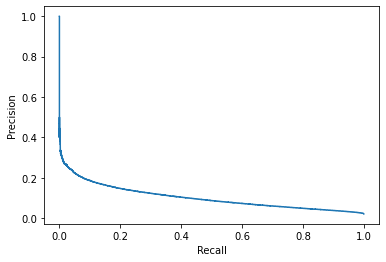

In [70]:
precision, recall, _ = precision_recall_curve(y_valid.purchased.astype(int), y_pred)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

precision, recall, _ = precision_recall_curve(y_valid.purchased.astype(int), y_pred_adj)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.show()

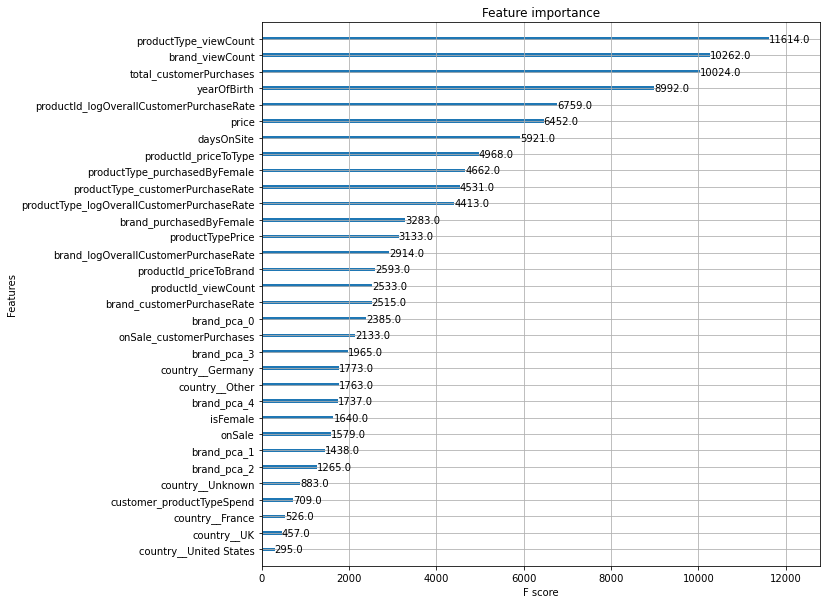

In [71]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
xgb.plot_importance(booster=model, ax=ax, importance_type="weight")
plt.show()

In [73]:
save_path = MODELS_DIR/'final_xgboost.joblib'

# joblib.dump(model, save_path)
clf = joblib.load(save_path)

In [74]:
submission = data.labels_testing_df.copy()
submission.purchase_probability = y_pred_adj

# submission.to_csv(PATH.parent/'reports'/'SUBMISSION.csv', index=False)

In [77]:
for device in(['gpu','cpu']):
    print(f'{device} predictor')
    clf.set_params(predictor=f"{device}_predictor")
    for batch_size in [10,100,1_000,10_000,100_000,10_000_000]:
        t = time.time()
        clf.predict(data.train.drop(columns=['purchased','customerId']).sample(batch_size, replace=True))
        print(f"""{batch_size} predictions in {time.time()-t} s""")

gpu predictor
10 predictions in 0.21049880981445312 s
100 predictions in 0.15949726104736328 s
1000 predictions in 0.11099934577941895 s
10000 predictions in 0.16050028800964355 s
100000 predictions in 0.5730006694793701 s
10000000 predictions in 28.555503368377686 s
cpu predictor
10 predictions in 0.045998573303222656 s
100 predictions in 0.054999589920043945 s
1000 predictions in 0.05600166320800781 s
10000 predictions in 0.19150066375732422 s
100000 predictions in 0.7610006332397461 s
10000000 predictions in 57.84849786758423 s


In [79]:
print("""gpu predictor
10 predictions in 0.21049880981445312 s
100 predictions in 0.15949726104736328 s
1000 predictions in 0.11099934577941895 s
10000 predictions in 0.16050028800964355 s
100000 predictions in 0.5730006694793701 s
10000000 predictions in 28.555503368377686 s
cpu predictor
10 predictions in 0.045998573303222656 s
100 predictions in 0.054999589920043945 s
1000 predictions in 0.05600166320800781 s
10000 predictions in 0.19150066375732422 s
100000 predictions in 0.7610006332397461 s
10000000 predictions in 57.84849786758423 s""")

gpu predictor
10 predictions in 0.21049880981445312 s
100 predictions in 0.15949726104736328 s
1000 predictions in 0.11099934577941895 s
10000 predictions in 0.16050028800964355 s
100000 predictions in 0.5730006694793701 s
10000000 predictions in 28.555503368377686 s
cpu predictor
10 predictions in 0.045998573303222656 s
100 predictions in 0.054999589920043945 s
1000 predictions in 0.05600166320800781 s
10000 predictions in 0.19150066375732422 s
100000 predictions in 0.7610006332397461 s
10000000 predictions in 57.84849786758423 s


# Analyse Performance on Test data

In [80]:
model = joblib.load(MODELS_DIR/'final_xgboost.joblib')

In [81]:
# create full dataset
data = DatasetComplete(random_seed=SEED)
data.load_datasets()

data.load_datasets_from_file(
    DATA_DIR/'processed'/'full'/f'train_full.feather',
    DATA_DIR/'processed'/'full'/f'valid_full.feather')

customers dataset retrieved (1/6)
products dataset retrieved (2/6)
purchases dataset retrieved (3/6)
views dataset retrieved (4/6)
labels training dataset retrieved (5/6)
labels testing dataset retrieved (6/6) - FINISHED


In [82]:
test_preds = pd.read_csv(PATH.parent/'reports'/'SUBMISSION.csv')

In [83]:
# import random

#list of customers who are in our test set
# and bought something from the test set in january
custs = \
(test_preds
 .merge(data.purchase_df.query("""date > '2016-12-31 23:59:59'"""),
        on=['customerId','productId'], how='left')
 [['customerId','productId','purchase_probability','purchasePrice']]
 .fillna(0)
 .groupby('customerId')
 .purchasePrice.mean()
 .loc[lambda x: x!=0]
 .index.tolist())

In [86]:
def get_ordered_preds(custId, vec_len):
    # this customers purch preds orderd by prob
    preds = (test_preds
    .query("""customerId==@custId""")
    .sort_values(by='purchase_probability')
    )

    # all purchases of this cust in jan
    sales = (data.purchase_df
    .query("""date > '2016-12-31 23:59:59'""")
    .query("""customerId==@custId""")
    )

    # True if cust bought the prod, false otherwise
    # sorted by purch prob
    pred_binary = (preds
    .merge(sales, on=['customerId','productId'], how='left')
    .sort_values(by='purchase_probability', ascending=False)
    .purchasePrice
    .notna()
    .values
    .astype(int)
    )

    # 
    if pred_binary.shape[0] <= vec_len:
        pred_binary = np.pad(pred_binary, (0, vec_len-pred_binary.shape[0]), constant_values=-1)
        
    return pred_binary[None,:vec_len]

vec_len = 20
pred_binarys = []

for _ in range(40):             
    custId = random.choice(custs)
    pred_binary = get_ordered_preds(custId, vec_len)
    pred_binarys.append(pred_binary)
    
pred_binarys = np.vstack(pred_binarys)

# fig = \
(px.imshow(pred_binarys, zmin=-1, zmax=1)
 .update_layout(
     coloraxis_showscale=False,
     width=500, height=1000,)
 .update_xaxes(showticklabels=False, title='<-----<br>Increasing Predicted<br>Purchase Probability')
 .update_yaxes(showticklabels=False)
 )

Rows are customers. For each customer we pick the 20 products with highest predicted purchase probability. Order them with most likely on the left. Yellow blocks are products which were indeed bought. If a customer viewed fewer than 20 products then we pad with blue. Good performance would have all the yellow boxes on the left side.

In [105]:
y_valid = \
(data.labels_testing_df
 .merge(data.purchase_df.query("""date > '12-31-2016 23:59:59'"""), on=['productId','customerId'], how='left')
 [['productId','customerId','purchasePrice']]
 .rename(columns={'purchasePrice':'purchased'}))

y_valid.loc[y_valid.purchased.notna(), 'purchased'] = True
y_valid.loc[y_valid.purchased.isna(), 'purchased'] = False

y_valid = y_valid.merge(test_preds, on=['customerId','productId'])

In [109]:
test_results = data.valid.copy()
test_results[['productId','purchased','purchase_probability']] = y_valid[['productId','purchased','purchase_probability']]
test_results

,customerId,purchase_probability,isFemale,yearOfBirth,isPremier,newCustomer,price,onSale,daysOnSite,productId_viewCount,...,brand_pca_3,brand_pca_4,country__France,country__Germany,country__Other,country__UK,country__United States,country__Unknown,productId,purchased
0,2,0.093958,1,1991,False,False,6700,False,-348,2,...,-0.707520,0.618652,False,True,False,False,False,False,4601984,False
1,2,0.026796,1,1991,False,False,1900,True,-336,1,...,-0.503906,-0.109497,False,True,False,False,False,False,5015355,False
2,2,0.099568,1,1991,False,False,1600,False,-51,2,...,-0.498779,0.185181,False,True,False,False,False,False,5022042,False
3,2,0.031019,1,1991,False,False,1800,False,-672,1,...,-0.498779,0.185181,False,True,False,False,False,False,5048287,False
4,2,0.007325,1,1991,False,False,5650,True,-225,1,...,-0.498779,0.185181,False,True,False,False,False,False,6016479,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3345256,399476,0.012922,1,1993,False,False,3500,False,-71,1,...,-0.503906,-0.109497,False,False,False,True,False,False,7188787,False
3345257,399476,0.012287,1,1993,False,False,3800,False,-34,1,...,-0.503906,-0.109497,False,False,False,True,False,False,7215288,False
3345258,399476,0.009782,1,1993,False,False,3500,False,-76,1,...,-0.112427,0.002674,False,False,False,True,False,False,7258955,False
3345259,399476,0.009291,1,1993,False,False,3000,False,-70,1,...,-0.396729,-0.023849,False,False,False,True,False,False,7272924,False


In [182]:
test_results.purchase_probability.mean()

0.0197740259644493

In [111]:
test_results.query("""purchase_probability > 0.5""")

,customerId,purchase_probability,isFemale,yearOfBirth,isPremier,newCustomer,price,onSale,daysOnSite,productId_viewCount,...,brand_pca_3,brand_pca_4,country__France,country__Germany,country__Other,country__UK,country__United States,country__Unknown,productId,purchased


In [112]:
(test_results
 .groupby(['newCustomer','purchased'])
 .purchase_probability.mean())

newCustomer  purchased
False        False        0.018947
             True         0.060507
True         False        0.001309
             True         0.008812
Name: purchase_probability, dtype: float64

In [113]:
(test_results
 .assign(purchase_probability=lambda df: (df.purchase_probability*100)//1)
 .groupby('purchase_probability')
 .agg({'purchased':['mean','count']})
 .purchased
 .plot()
 )

In [114]:
# how often is the most likely product bought?
custs_who_buy = \
(test_results
 # remove customers who buy nothing
 .groupby('customerId')
 .filter(lambda g: g.purchased.mean()>0))

In [126]:
def top_n_performance(n):
    # highest pred product for each customer who bought something
    top_n = \
    (custs_who_buy
    .sort_values(by='purchase_probability', ascending=False)
    .groupby('customerId')
    .purchase_probability
    .nlargest(n)
    .reset_index('customerId')
    #  .purchased
    #  .mean()
    )
    
    #     (custs_who_buy
    # .loc[top_n.index]
    # .groupby('customerId')
    # .agg(pct_topn_purchased=('purchased','mean'), pct_topn_count=('purchased','count'))
    # .reset_index()
    # .groupby(['pct_topn_count','pct_topn_purchased'])
    # .agg(pct_of_customers=('customerId','count'))
    # .groupby(level=0)
    # .transform(lambda x: 100*x/x.sum())
    # )

    return \
    (custs_who_buy
    # get their top n predictions
    .loc[top_n.index]
    # % of their topn that they bought
    .groupby(['customerId'])
    .agg(pct_topn_purchased=('purchased','mean'))
    # boolean - did they buy at least one of their top n
    .apply(lambda col: col !=0)
    .mean())

for n in [1,2,3,5,10]:
    print(top_n_performance(n))

pct_topn_purchased    0.342337
dtype: float64
pct_topn_purchased    0.498638
dtype: float64
pct_topn_purchased    0.59487
dtype: float64
pct_topn_purchased    0.711088
dtype: float64
pct_topn_purchased    0.842446
dtype: float64


In [127]:
n = 3

top_n = \
(custs_who_buy
.sort_values(by='purchase_probability', ascending=False)
.groupby('customerId')
.purchase_probability
.nlargest(n)
.reset_index('customerId')
#  .purchased
#  .mean()
)


In [128]:
success_custs = \
(custs_who_buy
.loc[top_n.index]
.groupby('customerId')
.filter(lambda g: g.purchased.mean()>0)
.customerId
.unique())

unsuccess_custs = \
(custs_who_buy
.loc[top_n.index]
.groupby('customerId')
.filter(lambda g: g.purchased.mean()==0)
.customerId
.unique())

In [169]:
(data.customer_df
 # only for customers in test set who buy something
 .eval(""" success = customerId in @success_custs""")
 .eval(""" unsuccess = customerId in @unsuccess_custs""")
 # does our top 3 include somethiong they bought?
 .query("""success==True or unsuccess==True""")
 .drop(columns=['unsuccess'])
 .groupby('isFemale')
 .agg({'success':'mean'})
 )

,success
isFemale,
False,0.642768
True,0.577950


In [159]:
grouped = (
test_results
[['customerId','productId','purchase_probability','purchased','isFemale']]
.groupby('isFemale'))

for g_id, group in grouped:
    print(g_id, mean_average_precision_score(
        group.customerId,
        group.purchased.astype(int),
        group.purchase_probability,
        n_partitions=5))

-1 0.44509732252982437
0 0    0.449202
dtype: float64
1 0.382717254720738


Model performance is poorer on female customers. Not only are there many more female customers, they also tend to view more products on average.

In [158]:
(data
 .views_df
 .merge(data.customer_df, on=['customerId'])
 .groupby(['isFemale','customerId'])
 .productId
 .count()
 .groupby(['isFemale'])
 .mean()
 )

isFemale
False    39.952459
True     56.481924
Name: productId, dtype: float64

In [130]:
(data.customer_df
 # only for customers in test set who buy something
 .eval(""" success = customerId in @success_custs""")
 .eval(""" unsuccess = customerId in @unsuccess_custs""")
 # does our top 3 include somethiong they bought?
 .query("""success==True or unsuccess==True""")
 .drop(columns=['unsuccess'])
 .groupby(['country'])
 .agg({'success':['mean','count']})
 .dropna()
 .droplevel(0, axis=1)
 .query("""count>500""")
 .sort_values(by='mean')
 )

,mean,count
country,,
Russia,0.550769,650
Germany,0.586414,2002
UK,0.598579,7177
United States,0.605056,1780
France,0.607089,2003
Australia,0.624842,789


In [164]:
test_results.columns

Index(['customerId', 'purchase_probability', 'isFemale', 'yearOfBirth',
       'isPremier', 'newCustomer', 'price', 'onSale', 'daysOnSite',
       'productId_viewCount', 'productType_viewCount', 'brand_viewCount',
       'productId_logOverallCustomerPurchaseRate',
       'productId_customerPurchaseRate',
       'productType_logOverallCustomerPurchaseRate',
       'productType_customerPurchaseRate',
       'brand_logOverallCustomerPurchaseRate', 'brand_customerPurchaseRate',
       'total_customerPurchases', 'onSale_customerPurchases',
       'customer_productTypeSpend', 'productTypePrice',
       'productType_purchasedByFemale', 'productId_priceToType',
       'productId_priceToBrand', 'brand_purchasedByFemale', 'brand_pca_0',
       'brand_pca_1', 'brand_pca_2', 'brand_pca_3', 'brand_pca_4',
       'country__France', 'country__Germany', 'country__Other', 'country__UK',
       'country__United States', 'country__Unknown', 'productId', 'purchased'],
      dtype='object')

In [168]:
for country in {'UK', 'France', 'United States', 'Germany','Unknown'}:
    tmp = test_results[test_results[f'country__{country}']==True]
    print(country, mean_average_precision_score(
        tmp.customerId,
        tmp.purchased.astype(int),
        tmp.purchase_probability, n_partitions=5))

Germany 0.37679699484175777
Unknown 0.36058220294555987
France 0.42280583505645936
UK 0.40373668777359534
United States 0.40111134943890436


In [198]:
(data.customer_df
 # only for customers in test set who buy something
 .eval(""" success = customerId in @success_custs""")
 .eval(""" unsuccess = customerId in @unsuccess_custs""")
 # does our top 3 include somethiong they bought?
 .query("""success==True or unsuccess==True""")
 .drop(columns=['unsuccess'])
 .groupby(['yearOfBirth'])
 .agg({'success':['mean','count']})
 .dropna()
 .droplevel(0, axis=1)
 .query("""count>20""")
 .loc[1910:2010]
 .reset_index()
 .melt(id_vars=['yearOfBirth'], value_vars=['mean', 'count'])
 .plot(x='yearOfBirth', facet_row='variable', y='value')
 .update_layout(height=600, width=1000, title='Purchase rate of top 3 predicted products')
 .update_xaxes(title='Year of Birth', selector={'anchor':'x'})
 .update_yaxes(rangemode='tozero', matches=None)
 .update_yaxes(title='% Successful', tickformat='0%', range=[0.55,0.7], selector={'anchor':'x2'})
 .update_yaxes(title='Customer Count', selector={'anchor':'x'})
 .for_each_annotation(lambda a: a.update(text=''))
 .add_hline(y=0.59487, row=0, line_dash="dot",
            annotation_text="mean=59%",
            annotation_position="bottom",
            annotation_x=0.25)
 .for_each_trace(lambda t: t.update(line_color=t.marker.color))
 )

In [172]:
grouped = (
test_results
[['customerId','productId','purchase_probability','purchased','yearOfBirth']]
.groupby('yearOfBirth'))

age_results = {}
for g_id, group in grouped:
    age_results[g_id] = mean_average_precision_score(
        group.customerId,
        group.purchased.astype(int),
        group.purchase_probability,
        n_partitions=1)

In [180]:
tmp = pd.DataFrame()
for year, value in age_results.items():
    if isinstance(value, float):
        tmp.loc[year,'mAP'] = value
        
tmp.loc[1910:2010].plot()

## Why are women and 1990-1999 harder to predict?

In [134]:
# tmp = \
(data.purchase_df
 .merge(data.customer_df, on=['customerId'])
 .merge(data.product_df, on=['productId'])
 .groupby(['isFemale','customerId'])
 .agg(nunique_types=('productType','nunique'), nunique_brands=('brand','nunique'))
 .unstack('isFemale')
 .agg(['mean','std'])
 )

nunique_types           nunique_brands          
isFemale         False      True          False      True
mean          3.577046  3.606721       3.344390  4.352364
std           3.013181  3.292179       3.531626  5.093614

In [135]:
(data.purchase_df
 .merge(data.customer_df, on=['customerId'])
 .merge(data.product_df, on=['productId'])
 .assign(yearOfBirth=lambda df: df.yearOfBirth//1)
#  .assign(yearOfBirth=lambda df: 10*(df.yearOfBirth//10))
 .groupby(['yearOfBirth','customerId'])
 .agg(nunique_types=('productType','nunique'), nunique_brands=('brand','nunique'))
 .loc[1960:2000]
 .unstack('yearOfBirth')
 .agg(['mean'])
 .T
 .reset_index()
 .plot(x='yearOfBirth',y='mean',facet_row='level_0')
 .update_layout(height=600, width=1000, title='Different ages buy more variety of products')
 .update_xaxes(title='Year of Birth', selector={'anchor':'x'})
 .update_yaxes(rangemode='tozero', matches=None)
 .update_yaxes(title='Mean Unique Product Types', selector={'anchor':'x2'})
 .update_yaxes(title='Mean Unique Brands', selector={'anchor':'x'})
 .for_each_annotation(lambda a: a.update(text=''))
 .for_each_trace(lambda t: t.update(line_color=t.marker.color))
)